# Build a Question Answering system over SQL data

Enabling a LLM system to query structured data is very different from unstructured text data. For **unstructured** text data, we use text embeddings that can be searched against a vector database. For **structured** data (e.g., relational database), we need the LLM to write and execute queries in SQL. 

In this guide we'll go over the basic ways to create a Q&A system over tabular data in databases. We will cover implementations using both **chains** and an **agent**. These systems will allow us to ask a question about the data in a database and get back a natural language answer. The main difference between chains and an agent is that our agent can query the database in a loop as many times as it needs to answer the question.


## ⚠️ Security note ⚠️

Building Q&A systems of SQL databases requires executing model-generated SQL queries. There are inherent risks in doing this. Make sure that your database connection permissions are always scoped as narrowly as possible for your agent's needs. This will reduce though **not** eliminate the risks of building a model-driven system. For more on general security best practices, see [LangChain Security Docs](https://python.langchain.com/v0.2/docs/security).

The code in this notebook is adapted from the LangChain tutorial: [Build a Question/Answering system over SQL data](https://python.langchain.com/v0.2/docs/tutorials/sql_qa).


## Architecture

At a high-level, the steps of these systems are:

1. **Convert question to SQL query**: Model converts user's question to a SQL query.
2. **Execute SQL query**: Execute the SQL query.
3. **Answer the question**: Model responds to user input using the database query results.


![Convert user's question to SQL](img/sql_usecase.png "Convert user's question to SQL")
**Figure 1**: Image from [LangChain tutorial](https://python.langchain.com/v0.2/docs/tutorials/sql_qa/#architecture)


## Setup

Before we begin, please make sure you have setup the `.env` file in the project 
directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables (e.g., API keys) for this notebook:

In [1]:
import os
from dotenv import load_dotenv

_ = load_dotenv()

assert os.environ.get("GOOGLE_API_KEY")

## Database

In this notebook we will use a SQLite connection with the [Chinook](https://github.com/lerocha/chinook-database) sample database. The database has already been created for you in the `db` directory.

![Chinook database ER diagram](img/chinook-database-er-diagram.png "Chinook database ER diagram")
**Figure 2**: Image from [`chinook-database` GitHub](https://github.com/lerocha/chinook-database)

We can interface with the database using the SQLAlchemy-driven [`SQLDatabase`](https://python.langchain.com/v0.2/api_reference/community/utilities/langchain_community.utilities.sql_database.SQLDatabase.html) class:

In [2]:
from langchain_community.utilities import SQLDatabase

# Open database in read-only (`ro`) mode.
database = SQLDatabase.from_uri(
    "sqlite:///db/Chinook.db?mode=ro"
)

print(f"SQL Dialect: {database.dialect}")
print(
    f"Tables: {database.get_usable_table_names()}"
)

SQL Dialect: sqlite
Tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [3]:
database.run("SELECT * FROM Artist LIMIT 10;")

"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

Great! 😀 We've got a SQL database that we can query. Now let's try hooking it up to an LLM.


## Chain

Chains (i.e., compositions of LangChain [Runnables](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel) support applications whose steps are predictable. We can create a simple chain that takes a question and does the following:
1. Convert the question into a SQL query.
2. Execute the SQL query.
3. Use the results to answer the original question.

There are scenarios not supported by this arrangement. For example, this system will execute a SQL query for any user input — even `"hello"`. Importantly, as we'll see below, some questions require more than one query to answer. We will address these scenarios in the [Agent](#Agent) section.

### Convert question to SQL query

Let's initialize a LLM that we will use in the chain. We will be using Google's [**Gemini 1.5 Flash**](https://ai.google.dev/gemini-api/docs/models/gemini#gemini-1.5-flash), since it offers a generous free tier for us to play around with.

In [5]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash", 
    temperature=0
)

The first step in a SQL chain or agent is to take the user input and convert it to a SQL query. LangChain comes with a built-in chain for this: [`create_sql_query_chain`](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.sql_database.query.create_sql_query_chain.html).

In [5]:
from langchain.chains import create_sql_query_chain

write_query = create_sql_query_chain(
    llm=llm, 
    db=database
)

response = write_query.invoke(
    input={
        "question": "How many employees are there?"
    }
)

response

'```sqlite\nSELECT COUNT(*) FROM Employee\n```'

If we try executing the generated SQL directly, we will encounter a syntax error:

In [6]:
try:
    print(
        database.run(response)
    )
except Exception as error:
    print(error)

(sqlite3.OperationalError) near "```sqlite
SELECT COUNT(*) FROM Employee
```": syntax error
[SQL: ```sqlite
SELECT COUNT(*) FROM Employee
```]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


This is because the LLM generates SQL with `sqlite` tags. Instead, we need to extract a valid SQL from the response. To do this, we will make the LLM return structured output.

> **See also**: [How to return structured data from a model](https://python.langchain.com/docs/how_to/structured_output/)

In [7]:
from pydantic import (
    BaseModel, 
    Field
)

class OutputFormat(BaseModel):
    """
    The expected output format.    
    """
    question: str = Field(
        description=(
            "The user's question."
        )
    )
    query: str = Field(
        description=(
            "A valid SQL query that can be "
            "executed against a SQLite database "
            "to answer the user's question."            
        )
    )

In [8]:
# Chain to extract a valid SQL from the 
# generated response
parse_sql = (
    llm.with_structured_output(
        schema=OutputFormat
    )
    | (lambda output: output.query)
)

chain = (
    write_query 
    | parse_sql
)

response = chain.invoke(
    input={
        "question": "How many employees are there?"
    }
)

response

'SELECT COUNT(*) FROM Employee'

Now, we can successfully execute the SQL query:

In [9]:
try:
    print(
        database.run(response)
    )
except Exception as error:
    print(error)

[(8,)]


We can look at the [LangSmith trace](https://smith.langchain.com/public/c0d0e922-9105-4974-b141-6898bf6e1eb4/r) to get a better understanding of what this chain is doing. We can also inspect the chain directly for its prompts. Looking at the prompt (below), we can see that it is:

* Dialect-specific. In this case it references SQLite explicitly.
* Has definitions for all the available tables.
* Has three examples rows for each table.

This technique is inspired by papers like [this](https://arxiv.org/pdf/2204.00498.pdf), which suggest showing examples rows and being explicit about tables improves performance. We can also inspect the full prompt like so:

In [10]:
chain.get_prompts()[0].pretty_print()

You are a SQLite expert. Given an input question, first create a syntactically correct SQLite query to run, then look at the results of the query and return the answer to the input question.
Unless the user specifies in the question a specific number of examples to obtain, query for at most 5 results using the LIMIT clause as per SQLite. You can order the results to return the most informative data in the database.
Never query for all columns from a table. You must query only the columns that are needed to answer the question. Wrap each column name in double quotes (") to denote them as delimited identifiers.
Pay attention to use only the column names you can see in the tables below. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.
Pay attention to use date('now') function to get the current date, if the question involves "today".

Use the following format:

Question: Question here
SQLQuery: SQL Query to run
SQLResult: Result

### Query Validation

The most error-prone part of any SQL chain or agent is writing valid and safe SQL queries. We can make use of LangChain's built-in [`QuerySQLCheckerTool`](https://python.langchain.com/v0.2/api_reference/community/tools/langchain_community.tools.sql_database.tool.QuerySQLCheckerTool.html) that uses an LLM to check the SQL query for common mistakes.

> **See also**: [How to do query validation](https://python.langchain.com/docs/how_to/sql_query_checking/)

In [11]:
from langchain_community.tools import QuerySQLCheckerTool

check_query = QuerySQLCheckerTool(
    db=database, 
    llm=llm
)

Let's check out the prompt that is used for checking the query:

In [12]:
from langchain_core.prompts import PromptTemplate

PromptTemplate.from_template(
    template=check_query.template
).pretty_print()


{query}
Double check the {dialect} query above for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

Output the final SQL query only.

SQL Query: 


Try running it on an incorrect SQL query (❌`NOT IN NULL` instead of ✅`IS NOT NULL`):

In [13]:
check_query.invoke(
    input={
        "query": "SELECT * FROM Employee WHERE LastName NOT IN NULL;"
    }
)

'```sqlite\nSELECT * FROM Employee WHERE LastName IS NOT NULL;\n```'

We can see that the LLM corrected our query. Let's move on to executing the query.

### Execute SQL query

Now that we've generated a SQL query, we'll want to execute it. **This is the most dangerous part of creating a SQL chain.** Consider carefully if it is OK to run automated queries over your data. Minimize the database connection permissions as much as possible. Consider adding a human approval step to your chains before query execution.

We can use the [`QuerySQLDatabaseTool`](https://python.langchain.com/api_reference/community/tools/langchain_community.tools.sql_database.tool.QuerySQLDataBaseTool.html) to easily add query execution to our chain:

In [14]:
from langchain_community.tools.sql_database.tool import (
    QuerySQLDataBaseTool
)

execute_query = QuerySQLDataBaseTool(
    db=database
)

chain = (
    write_query 
    | check_query
    | parse_sql
    | execute_query
)

response = chain.invoke(
    input={
        "question": "How many employees are there?"
    }
)

response

'[(8,)]'

### Answer the question

Now that we've got a way to automatically generate and execute queries, we just need to combine the original question and SQL query result to generate a final answer. We can do this by passing question and result to the LLM once more:

In [15]:
from langchain_core.prompts import PromptTemplate

answer_prompt = PromptTemplate.from_template(
    "Given the following user question, "
    "corresponding SQL query, and SQL result, "
    "answer the user question.\n\n" 
    "Question: {question}\n"
    "SQL Query: {query}\n"
    "SQL Result: {result}\n"
    "Answer: "
)

answer_prompt.pretty_print()

Given the following user question, corresponding SQL query, and SQL result, answer the user question.

Question: {question}
SQL Query: {query}
SQL Result: {result}
Answer: 


In [16]:
from operator import itemgetter

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough


chain = (
    RunnablePassthrough.assign(
        query=(
            write_query 
            | check_query 
            | parse_sql
        )
    ).assign(
        result=(
            itemgetter("query") 
            | execute_query
        )
    )
    | answer_prompt
    | llm
    | StrOutputParser()
)

response = chain.invoke(
    input={
        "question": "How many employees are there?"
    }
)

response

'There are **8** employees. \n'

Let's review what is happening in the above LangChain Expression Language (LCEL). When this chain is invoked:

- After the first `RunnablePassthrough.assign`, we have a runnable with two keys:
    ```python
    {
        "question": "How many employees are there?",
        "query": write_query.invoke(question)
    }
    ```
where `write_query` will generate a SQL query to answer the user's `question`.

- After the second `RunnablePassthrough.assign`, we have add a third key `"result"` that contains `execute_query.invoke(query)`, where `query` was computed in the previous step.
    ```python
    {
        "question": "How many employees are there?",
        "query": write_query.invoke(question),
        "result": execute_query.invoke(query)
    }
    ```
    
- These three inputs are formatted into the prompt and passed into the LLM.
- The `StrOutputParser()` plucks out the string content of the output message.

Note that we are composing LLMs, tools, prompts, and other chains together, but because each implements the `Runnable` interface, their inputs and outputs can be tied together in a reasonable way.

> **See also**: [LangChain Expression Language Cheatsheet](https://python.langchain.com/docs/how_to/lcel_cheatsheet/)

## Agent

LangChain has a SQL Agent which provides a more flexible way of interacting with SQL Databases than a chain. The main advantages of using the SQL Agent are:

- It can answer questions based on the database's schema as well as on the databases' content (e.g., describing a specific table).
- It can recover from errors by running a generated SQL, catching the error and re-generate a new corrected SQL.
- It can query the database as many times as needed to answer the user question.
- It will save tokens by only retrieving the schema for relevant tables.

To initialize the agent we'll use the [`SQLDatabaseToolkit`](https://python.langchain.com/docs/integrations/tools/sql_database/) to create a bunch of tools:

In [6]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(
    db=database, 
    llm=llm
)

tools = toolkit.get_tools()

Let's see what tools are available inside the `SQLDatabaseToolkit`:

In [7]:
for tool in tools:
    print(f"{tool.__class__}")
    print(f"name: {tool.name}")
    print(f"description: {tool.description}", end="\n---\n")

<class 'langchain_community.tools.sql_database.tool.QuerySQLDataBaseTool'>
name: sql_db_query
description: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
---
<class 'langchain_community.tools.sql_database.tool.InfoSQLDatabaseTool'>
name: sql_db_schema
description: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3
---
<class 'langchain_community.tools.sql_database.tool.ListSQLDatabaseTool'>
name: sql_db_list_tables
description: Input is an empty string, output is a comma-separated list of tables in the database

### System Prompt

We will also want to create a system prompt for our agent. This will consist of instructions for how to behave.

Let's load the system prompt template from a file, since it is quite a long prompt:

In [9]:
from langchain_core.prompts import PromptTemplate

system_prompt = PromptTemplate.from_file(
    template_file="prompts/system-prompt-template.txt"
)

Take a peek at the prompt template:

In [10]:
system_prompt.pretty_print()

You are an agent designed to interact with a SQLite database.
Given a user's question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

You have access to the following tables in the database: 
{table_names}

When answering the user's question, follow these steps:

1. Decide which tables are relevant to the user's question. Fetch the schema and sample rows for the relevant tables using the `sql_db_schema` tool.

2. With the schema, generate a syntactically correct SQLite query. Use the following guidelines when generating the query:
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results (i.e., `LIMIT 5`).
- You can order the results by a relevant column to return the most interesting examples in the database (e.g., `ORDER BY Invoice.Total`).
- Never query for all the columns from a specific table, only ask for the relevant columns given the question. For

Feed the comma separated table names into the prompt template:

In [11]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(
    content=system_prompt.format(
        table_names=", ".join(
            database.get_usable_table_names()
        )
    )
)

In [12]:
system_message.pretty_print()

================================ System Message ================================

You are an agent designed to interact with a SQLite database.
Given a user's question, create a syntactically correct SQLite query to run, then look at the results of the query and return the answer.

You have access to the following tables in the database: 
Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track

When answering the user's question, follow these steps:

1. Decide which tables are relevant to the user's question. Fetch the schema and sample rows for the relevant tables using the `sql_db_schema` tool.

2. With the schema, generate a syntactically correct SQLite query. Use the following guidelines when generating the query:
- Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results (i.e., `LIMIT 5`).
- You can order the results by a relevant column to return the most interesting

### Initialize the agent

We will make use of [LangGraph's pre-built agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#create_react_agent) for our SQL agent, instead of building one from scratch:

In [13]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent


agent_graph = create_react_agent(
    model=llm, 
    tools=tools, 
    state_modifier=system_message
)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'default' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


Let's visualize the graph representing the agent's workflow:

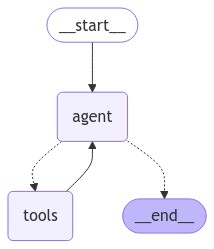

In [14]:
from IPython.display import Image, display

display(
    Image(
        agent_graph.get_graph().draw_mermaid_png()
    )
)

Create a helper function to stream back values from the graph. This allows us to see what the agent is doing at each step.

In [15]:
from langgraph.graph import Graph


def stream_graph_values(
    graph: Graph,
    user_input: str,    
) -> None:
    inputs = {
        "messages": [
            ("human", user_input)            
        ]
    }
    
    for chunk in graph.stream(
        input=inputs, 
        stream_mode="values"
    ):
        chunk["messages"][-1].pretty_print()

Consider how the agent responds to the below question:

In [17]:
stream_graph_values(
    graph=agent_graph,
    user_input="Which country's customers spent the most?",    
)

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (ab2dbb20-22e2-48a9-ae6b-41c14dcfa506)
 Call ID: ab2dbb20-22e2-48a9-ae6b-41c14dcfa506
  Args:
    table_names: Customer, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCHAR(20) NOT NULL, 
	"Company" NVARCHAR(80), 
	"Address" NVARCHAR(70), 
	"City" NVARCHAR(40), 
	"State" NVARCHAR(40), 
	"Country" NVARCHAR(40), 
	"PostalCode" NVARCHAR(10), 
	"Phone" NVARCHAR(24), 
	"Fax" NVARCHAR(24), 
	"Email" NVARCHAR(60) NOT NULL, 
	"SupportRepId" INTEGER, 
	PRIMARY KEY ("CustomerId"), 
	FOREIGN KEY("SupportRepId") REFERENCES "Employee" ("EmployeeId")
)

/*
3 rows from Customer table:
CustomerId	Fir

Notice that the agent will use different tools at its disposal until it has all the information it needs to answer the user's question:
1. Retrieves the schema for the relevant tables.
2. Query the tables via a `INNER JOIN` operation.
3. Check the generated query for common mistakes before executing the query.

The agent is then able to use the result of the final query to generate an answer to the original question.

The agent can similarly handle qualitative questions:

In [18]:
stream_graph_values(
    graph=agent_graph,
    user_input="Describe the PlaylistTrack table.",
)

================================ Human Message =================================

Describe the PlaylistTrack table.
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (4558b828-54bd-4266-8c7d-5520ea277123)
 Call ID: 4558b828-54bd-4266-8c7d-5520ea277123
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("PlaylistId", "TrackId"), 
	FOREIGN KEY("TrackId") REFERENCES "Track" ("TrackId"), 
	FOREIGN KEY("PlaylistId") REFERENCES "Playlist" ("PlaylistId")
)

/*
3 rows from PlaylistTrack table:
PlaylistId	TrackId
1	3402
1	3389
1	3390
*/
================================== Ai Message ==================================

The PlaylistTrack table has two columns: PlaylistId and TrackId. It stores the relationship between playlists and tracks. Each 

Let's try it out with a more difficult question that requires pulling information in from multiple tables:

In [20]:
stream_graph_values(
    graph=agent_graph,
    user_input="What is the total price for the album 'Big Ones'?"
)

================================ Human Message =================================

What is the total price for the album 'Big Ones'?
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (97e06c6b-cd68-4ba5-97ab-a259d3051beb)
 Call ID: 97e06c6b-cd68-4ba5-97ab-a259d3051beb
  Args:
    table_names: Album, Track, InvoiceLine
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Album" (
	"AlbumId" INTEGER NOT NULL, 
	"Title" NVARCHAR(160) NOT NULL, 
	"ArtistId" INTEGER NOT NULL, 
	PRIMARY KEY ("AlbumId"), 
	FOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")
)

/*
3 rows from Album table:
AlbumId	Title	ArtistId
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE "InvoiceLine" (
	"InvoiceLineId" INTEGER NOT NULL, 
	"InvoiceId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	"UnitPrice" NUMERIC(10, 2) NOT NULL, 
	"Qua

Notice that the generated SQL above is wrong (join on incorrect column) and thus returns an incorrect answer. For more complex queries, the LLM will need some help from us.

### Few-shot Examples

Including examples of natural language questions being converted to valid SQL queries against our database in the prompt will often improve model performance, especially for complex queries.

> Further reading:
> * [How to better prompt when doing SQL question-answering](https://python.langchain.com/docs/how_to/sql_prompting/)
> * [How to use few shot examples](https://python.langchain.com/docs/how_to/few_shot_examples/)

Let's load in some examples from a JSON file. To see how the examples in the JSON file were created, take a look at this [notebook](examples-to-json.ipynb).

In [21]:
import json

with open(
    file="examples/examples.json", 
    encoding="utf-8"
) as f:
    examples = json.load(f)

# print out a few examples
examples[:3]

[{'question': 'What is the most popular media type among all the tracks?',
  'query': 'SELECT MediaType.Name AS media_type, COUNT(Track.TrackId) AS track_count FROM Track INNER JOIN MediaType ON MediaType.MediaTypeId = Track.MediaTypeId GROUP BY Track.MediaTypeId ORDER BY track_count DESC LIMIT 5;'},
 {'question': "What is the total price for the album 'Big Ones'?",
  'query': "SELECT Album.Title AS album_title, SUM(Track.UnitPrice) AS album_price FROM Track INNER JOIN Album ON Album.AlbumId = Track.AlbumId WHERE Album.Title = 'Big Ones' GROUP BY Track.AlbumId;"},
 {'question': 'Which tracks made the most in total sales?',
  'query': 'SELECT Track.Name AS track_name, SUM( InvoiceLine.Quantity * InvoiceLine.UnitPrice ) AS total_sales FROM InvoiceLine INNER JOIN Track ON InvoiceLine.TrackId = Track.TrackId GROUP BY InvoiceLine.TrackId ORDER BY total_sales DESC LIMIT 5;'}]

An example looks like:

```python
{
    "question": "How many employees are there?"
    "query": "SELECT COUNT(*) FROM Employee;"
}
```

where the `question` key is the user's question and the `query` key is the SQL query used to fetch the relevant data to answer the user's question.


#### Select relevant examples

If we have a lot of examples, we may want to only include the most relevant ones in the prompt. Either, because they don't fit in the model's context window or because the irrelevant examples end up distracting the model. So, given a user's question, we only want to include the most relevant examples.

We can do this using LangChain's [Example Selectors](https://python.langchain.com/docs/concepts/#example-selectors). In this case we'll use a [`SemanticSimilarityExampleSelector`](https://python.langchain.com/docs/how_to/example_selectors_similarity/), which will store the examples in a vector database. At runtime it will perform a similarity search between the user's question and our examples, and return the most semantically similar ones (i.e., the ones with the most similar meaning).

Here we are using [FAISS](https://python.langchain.com/docs/integrations/vectorstores/faiss/) as our vector store and Google's Generative AI [text embedding model](https://ai.google.dev/gemini-api/docs/models/gemini#text-embedding) since we are using **Gemini 1.5 Flash**:

In [23]:
from langchain_community.vectorstores import FAISS
from langchain_core.example_selectors import (
    SemanticSimilarityExampleSelector
)
from langchain_google_genai import GoogleGenerativeAIEmbeddings


example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples=examples,
    embeddings=GoogleGenerativeAIEmbeddings(
        model="models/text-embedding-004"
    ),
    vectorstore_cls=FAISS,
    k=4, # returns the top 4 most similar examples
    input_keys=["question"],
)

In [24]:
example_selector.select_examples(
    {"question": "What is the total price for the album 'Big Ones'?"}
)

[{'question': "What is the total price for the album 'Big Ones'?",
  'query': "SELECT Album.Title AS album_title, SUM(Track.UnitPrice) AS album_price FROM Track INNER JOIN Album ON Album.AlbumId = Track.AlbumId WHERE Album.Title = 'Big Ones' GROUP BY Track.AlbumId;"},
 {'question': "How many tracks are there in the album 'Big Ones'?",
  'query': "SELECT Album.Title AS album_title, COUNT(Track.TrackId) AS track_count FROM Track INNER JOIN Album ON Album.AlbumId = Track.AlbumId WHERE Album.Title = 'Big Ones';"},
 {'question': 'Which tracks made the most in total sales?',
  'query': 'SELECT Track.Name AS track_name, SUM( InvoiceLine.Quantity * InvoiceLine.UnitPrice ) AS total_sales FROM InvoiceLine INNER JOIN Track ON InvoiceLine.TrackId = Track.TrackId GROUP BY InvoiceLine.TrackId ORDER BY total_sales DESC LIMIT 5;'},
 {'question': 'Which tracks sold the most number of units?',
  'query': 'SELECT Track.Name, SUM(InvoiceLine.Quantity) AS total_quantity FROM InvoiceLine INNER JOIN Track ON

#### Create a formatter for the few-shot examples

Configure a formatter that will format the few-shot examples into a string. This formatter should be a [`PromptTemplate`](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.prompt.PromptTemplate.html) object.

In [25]:
from langchain_core.prompts import PromptTemplate

example_prompt = PromptTemplate.from_template(
    "Question: {question}\n"
    "SQL query: {query}"
)

example_prompt.pretty_print()

Question: {question}
SQL query: {query}


Let's test the formatting prompt with one of our examples:

In [26]:
print(
    example_prompt.format(**examples[0])
)

Question: What is the most popular media type among all the tracks?
SQL query: SELECT MediaType.Name AS media_type, COUNT(Track.TrackId) AS track_count FROM Track INNER JOIN MediaType ON MediaType.MediaTypeId = Track.MediaTypeId GROUP BY Track.MediaTypeId ORDER BY track_count DESC LIMIT 5;


#### Pass example selector and formatter to `FewShotPromptTemplate`

Create a [`FewShotPromptTemplate`](https://python.langchain.com/api_reference/core/prompts/langchain_core.prompts.few_shot.FewShotPromptTemplate.html) object. This object takes in the example selector and the formatter prompt we defined above for the few-shot examples. When this `FewShotPromptTemplate` is formatted, it formats the passed examples using the `example_prompt` formatter.

The `prefix` part of the prompt comes **before** the few-shot examples. The `suffix` part comes **after** the few-shot examples.

In [27]:
from langchain_core.prompts import FewShotPromptTemplate

few_shot_prompt = FewShotPromptTemplate(
    example_selector=example_selector,
    example_prompt=example_prompt,
    prefix=(
        "Here are some examples of questions "
        "and their corresponding SQL queries."
    ),
    suffix=(
        "Question: {question}\n"
        "SQL query: "
    ),
    input_variables=["question"],
)

Let's test out the `FewShotPromptTemplate` by invoking it with a sample  question:

In [29]:
print(
    few_shot_prompt.format(
        question="What is the total price for the album 'Big Ones'?"
    )
)

Here are some examples of questions and their corresponding SQL queries.

Question: What is the total price for the album 'Big Ones'?
SQL query: SELECT Album.Title AS album_title, SUM(Track.UnitPrice) AS album_price FROM Track INNER JOIN Album ON Album.AlbumId = Track.AlbumId WHERE Album.Title = 'Big Ones' GROUP BY Track.AlbumId;

Question: How many tracks are there in the album 'Big Ones'?
SQL query: SELECT Album.Title AS album_title, COUNT(Track.TrackId) AS track_count FROM Track INNER JOIN Album ON Album.AlbumId = Track.AlbumId WHERE Album.Title = 'Big Ones';

Question: Which tracks made the most in total sales?
SQL query: SELECT Track.Name AS track_name, SUM( InvoiceLine.Quantity * InvoiceLine.UnitPrice ) AS total_sales FROM InvoiceLine INNER JOIN Track ON InvoiceLine.TrackId = Track.TrackId GROUP BY InvoiceLine.TrackId ORDER BY total_sales DESC LIMIT 5;

Question: Which tracks sold the most number of units?
SQL query: SELECT Track.Name, SUM(InvoiceLine.Quantity) AS total_quantity 

#### Pass few-shot prompt to agent

Format the `FewShotPromptTemplate` object with the user's question to fetch the most relevant examples to the user's question. Pass this in to the same agent as before:

In [30]:
stream_graph_values(
    graph=agent_graph,
    user_input=few_shot_prompt.format(
        question="What is the total price for the album 'Big Ones'?"
    )    
)

================================ Human Message =================================

Here are some examples of questions and their corresponding SQL queries.

Question: What is the total price for the album 'Big Ones'?
SQL query: SELECT Album.Title AS album_title, SUM(Track.UnitPrice) AS album_price FROM Track INNER JOIN Album ON Album.AlbumId = Track.AlbumId WHERE Album.Title = 'Big Ones' GROUP BY Track.AlbumId;

Question: How many tracks are there in the album 'Big Ones'?
SQL query: SELECT Album.Title AS album_title, COUNT(Track.TrackId) AS track_count FROM Track INNER JOIN Album ON Album.AlbumId = Track.AlbumId WHERE Album.Title = 'Big Ones';

Question: Which tracks made the most in total sales?
SQL query: SELECT Track.Name AS track_name, SUM( InvoiceLine.Quantity * InvoiceLine.UnitPrice ) AS total_sales FROM InvoiceLine INNER JOIN Track ON InvoiceLine.TrackId = Track.TrackId GROUP BY InvoiceLine.TrackId ORDER BY total_sales DESC LIMIT 5;

Question: Which tracks sold the most number of

As we can see, given relevant examples on how to generate the SQL query, the agent successfully answers the question. Without these examples, the agent got the answer wrong previously.

Let's try it out on one more complex question that the agent failed miserably on during testing. This question requires pulling in information from multiple tables and also use of SQLite's date function to extract the year.

In [33]:
stream_graph_values(
    graph=agent_graph,
    user_input=few_shot_prompt.format(
        question="Which employee made the most in sales in the year 2021?"
    )    
)

================================ Human Message =================================

Here are some examples of questions and their corresponding SQL queries.

Question: Which employee made the most in sales in the year 2021?
SQL query: SELECT CONCAT( Employee.FirstName, ' ', Employee.LastName ) AS full_name, Employee.Title AS job_title, strftime('%Y', Invoice.InvoiceDate) AS invoice_year, SUM(Invoice.Total) AS total_sales_made FROM Employee INNER JOIN Customer ON Customer.SupportRepId = Employee.EmployeeId INNER JOIN Invoice ON Invoice.CustomerId = Customer.CustomerId WHERE invoice_year = '2021' GROUP BY Employee.EmployeeId ORDER BY total_sales_made DESC LIMIT 5;

Question: Which employees made the most in sales?
SQL query: SELECT CONCAT( Employee.FirstName, ' ', Employee.LastName ) AS full_name, Employee.Title AS job_title, SUM(Invoice.Total) AS total_sales_made FROM Employee INNER JOIN Customer ON Customer.SupportRepId = Employee.EmployeeId INNER JOIN Invoice ON Invoice.CustomerId = Cus

Again with the relevant examples fed to the agent, it can successfully answer the question.


## Conclusion

In this notebook, we have seen how to use LLMs to do question